In [2]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from faraway.datasets import galapagos

In [3]:
# Load the galapagos dataset
data = galapagos.load()

In [4]:
data.tail()

,Species,Area,Elevation,Nearest,Scruz,Adjacent
SantaFe,62,24.08,259,16.5,16.5,0.52
SantaMaria,285,170.92,640,2.6,49.2,0.10
Seymour,44,1.84,147,0.6,9.6,25.09
Tortuga,16,1.24,186,6.8,50.9,17.95
Wolf,21,2.85,253,34.1,254.7,2.33


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30 entries, Baltra to Wolf
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Species    30 non-null     int64  
 1   Area       30 non-null     float64
 2   Elevation  30 non-null     int64  
 3   Nearest    30 non-null     float64
 4   Scruz      30 non-null     float64
 5   Adjacent   30 non-null     float64
dtypes: float64(4), int64(2)
memory usage: 1.6+ KB


In [6]:
# Define the independent variables (predictors) and add a constant
X = data[['Area', 'Elevation', 'Nearest']]
X = sm.add_constant(X)  # Adds a constant for the intercept

# Define the dependent variable
y = data['Species']

# Verify the shapes of X and y
print(X.shape, y.shape)

(30, 4) (30,)


In [8]:
X.head()

,const,Area,Elevation,Nearest
Baltra,1.0,25.09,346,0.6
Bartolome,1.0,1.24,109,0.6
Caldwell,1.0,0.21,114,2.8
Champion,1.0,0.10,46,1.9
Coamano,1.0,0.05,77,1.9


In [9]:
# Fit the Multiple Linear Regression model
model = sm.OLS(y, X).fit()

# Print the model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                Species   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     10.77
Date:                Mon, 16 Jun 2025   Prob (F-statistic):           8.82e-05
Time:                        22:55:35   Log-Likelihood:                -172.20
No. Observations:                  30   AIC:                             352.4
Df Residuals:                      26   BIC:                             358.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         16.4647     23.389      0.704      0.4

Model Performance:

Adjusted R2: 0.503

Adjusted R2 accounts for the number of predictors in the model, penalizing unnecessary predictors.

While r2 indicates that 55.4% of the variation in Species is explained by the model, the Adjusted of 0.503 suggests that some predictors may not add significant value and the model explains about 50.3% of the variability after accounting for the number of predictors.

F-statistic: 10.77 (p-value = 8.82e-05)

The F-statistic tests the overall significance of the model. A small p-value (< 0.05) indicates that the predictors, as a group, explain a statistically significant proportion of the variability in Species.

Elevation is the only statistically significant predictor (p = 0.004), indicating that islands with higher elevation tend to have more plant species.

Area and Nearest are not significant (p > 0.05), suggesting they do not explain the variation in Species after accounting for Elevation.

## Check for multicollinearity

               Area  Elevation   Nearest
Area       1.000000   0.753735 -0.111103
Elevation  0.753735   1.000000 -0.011077
Nearest   -0.111103  -0.011077  1.000000


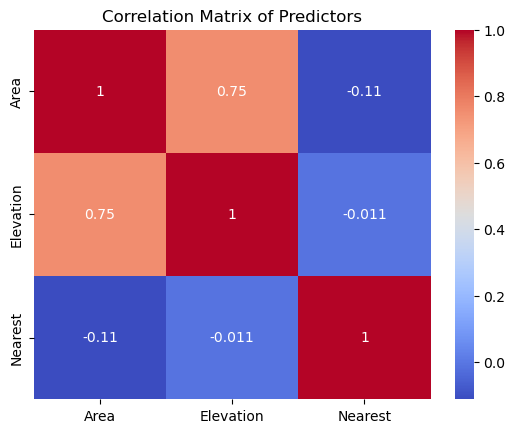

In [10]:
# Calculate the correlation matrix
correlation_matrix = data[['Area', 'Elevation', 'Nearest']].corr()
print(correlation_matrix)

# Visualize the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Predictors')
plt.show()

Variable Pair	Correlation Coefficient	Interpretation

Area & Elevation	0.75	Strong positive correlation: As Area increases, Elevation also tends to increase.

Area & Nearest	-0.11	Weak negative correlation: Area and Nearest are almost uncorrelated.

Elevation & Nearest	-0.01	Very weak negative correlation: Essentially no relationship.

Why Multicollinearity is a Concern?

The strong correlation (0.75) between Area and Elevation suggests potential multicollinearity:

Multicollinearity occurs when predictor variables are highly correlated.

It inflates the variance of the regression coefficients, leading to: Unstable estimates for the coefficients, Increased standard errors, Difficulty determining which predictor is significant.

## Check for multicollinearity using VIF

In [17]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define predictors (excluding the dependent variable 'Species')
X = data[['Area', 'Elevation', 'Nearest']]
X = sm.add_constant(X)  # Add constant for intercept

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Variable'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

    Variable       VIF
0      const  2.511156
1       Area  2.373470
2  Elevation  2.344460
3    Nearest  1.025189


Area (VIF = 2.37) and Elevation (VIF = 2.34):

1) Both predictors show low to moderate multicollinearity (VIF < 5).
2) This indicates that Area and Elevation are correlated, which aligns with the correlation matrix results where their correlation was 0.75.
3) While not severe, the moderate multicollinearity could slightly inflate the standard errors of their coefficients. However, it is still within an acceptable range, so no immediate corrective action is needed.

Nearest (VIF = 1.03):

1) This variable has a very low VIF, indicating no multicollinearity with the other predictors.
2) It can be confidently included in the model without concerns of redundancy.

Constant Term (const, VIF = 2.51):
The intercept has a moderate VIF value. This is typical and does not directly impact the interpretation of the predictor variables. It simply reflects the scaling and centering of the predictors.

### Visualization - Residuals

In [11]:
# Get the residuals
residuals = model.resid

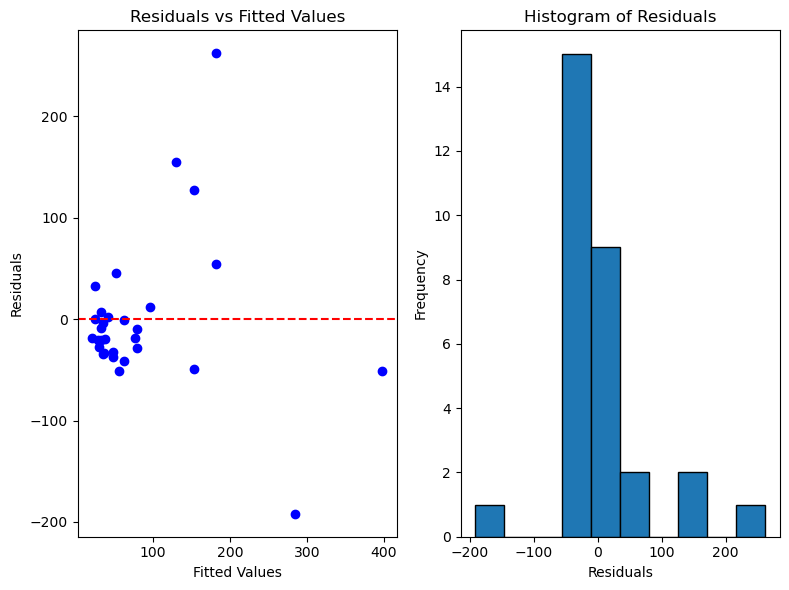

In [13]:
# Create a 2x1 grid for the plots
fig, axes = plt.subplots(1, 2, figsize=(8, 6))  # 2 rows, 1 column


# Plot 1: Residuals vs Fitted Values
axes[0].scatter(model.fittedvalues, residuals, color='blue')
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted Values')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')


# Plot 2: Histogram of Residuals
axes[1].hist(residuals, bins=10, edgecolor='black')
axes[1].set_title('Histogram of Residuals')
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')


# Adjust layout
plt.tight_layout()


# Show the plots
plt.show()

Residuals vs. Fitted Values Plot (Left)
Purpose: This plot is used to assess the assumption of homoscedasticity (constant variance of residuals) and check for any patterns in residuals.

1) In the plot, the residuals appear scattered unevenly around the red horizontal line at zero, with a few noticeable outliers far from the center.
2) There is a concentration of residuals near lower fitted values and larger spread in higher fitted values. This suggests possible heteroscedasticity (non-constant variance).
3) A few points are significantly distant from the zero line, which may indicate outliers or influential observations that could disproportionately affect the regression results.
   
Conclusion: The lack of even scatter and potential funneling of residuals indicates a violation of the homoscedasticity assumption, which should be addressed through further diagnostics, transformations, or robust regression methods.

Histogram of Residuals (Right)
Purpose: This histogram checks whether the residuals are approximately normally distributed, which is essential for valid statistical inferences (e.g., hypothesis tests, confidence intervals).

1) The histogram of residuals is not perfectly symmetric and exhibits a right-skewed distribution, with a notable cluster of residuals near zero and some extreme residuals at both ends.
2) This deviation from normality suggests that the residuals are not centered around zero in a bell-curve shape, which violates the normality of residuals assumption.

Conclusion: Non-normal residuals indicate that the regression model may not fully capture the variability in the data, potentially leading to inaccurate p-values or confidence intervals.

## Prediction

In [15]:
# Define new data for prediction
# We are preparing a new observation (input) to feed into a regression model for prediction.
# The order DO MATTER

new_data = pd.DataFrame({'const': [1], 'Area': [10], 'Elevation': [100], 'Nearest': [1.5]})

In [16]:
# Predict the number of species
prediction = model.predict(new_data)
print(f"Predicted number of species: {prediction[0]:.2f}")

Predicted number of species: 33.90


## Summary

Model Performance:
1) The model explains approximately 55.4% of the variation in the number of species based on the predictors (Area, Elevation, Nearest).
2) Adjusted R2 is 0.503, accounting for the number of predictors and indicating the model’s performance after penalizing unnecessary predictors.

Significant Predictor among the predictors:

1) Elevation has a statistically significant positive effect (p=0.04). For every unit increase in Elevation, the number of species increases by approximately 0.17.
2) Area and Nearest are not significant (p>0.05), meaning they do not contribute meaningfully to predicting the number of species after considering Elevation.

Multicollinearity:
1) Correlation analysis showed a strong relationship (r=0.75) between Area and Elevation.
2) VIF values for Area (2.37) and Elevation (2.34) confirmed moderate multicollinearity but within acceptable limits ( VIF<5).

Residual Diagnostics:

1) Residuals vs. Fitted Plot: Indications of heteroscedasticity were observed, as the residuals are unevenly scattered, particularly at higher fitted values.
2) Histogram of Residuals: Residuals are right-skewed and deviate from normality, which may affect the validity of statistical inferences.

Prediction:

1) Using the model, we predicted that a new island with an Area = 10, Elevation = 100, and Nearest = 1.5 will have approximately 33.90 species.
2) This prediction is based on the fitted regression equation and is a useful estimate for ecological planning or prioritizing islands for conservation.

Final Recommendations

**While Elevation is significant and useful for predictions, the lack of normality and heteroscedasticity in residuals suggests that improvements can be made to the model**

Next Steps:
1) Address heteroscedasticity by transforming predictors or responses (e.g., log transformation).
2) Investigate the inclusion of other ecological variables that may better explain species richness.
3) Consider robust regression methods if influential outliers persist.
   
By summarizing these findings, you can see how to assess model results critically, identify limitations, and propose actionable improvements in real-world data science workflows.